# Введение в gymnasium. Создание кастомной среды и обучение DQN-агента

---
#### Сегодня мы:
- Создадим кастомную среду в Gymnasium, аналогичную классической CartPole (обратный маятник)
- Обучим агента с помощью Deep Q-Network (DQN)
- Увидим, как гиперпараметры влияют на обучение модели

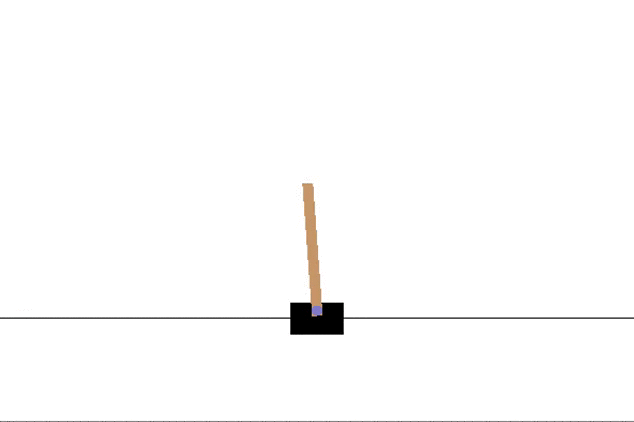

Официальный гайд на создание кастомных сред в Gymnasium - https://gymnasium.farama.org/introduction/create_custom_env/

## Устанавливаем необходимые библиотеки


In [ ]:
!pip install gymnasium
!pip install pyvirtualdisplay # нужен для рендеринга в колабе

Мы будем создавать среду, идентичную CartPole

Структура проекта:


```
dima@dima-TBk-14-G7-AHP:~/projects/RL_course_2$ tree
.
├── gymnasium_env_RL_course
│   ├── envs
│   │   ├── cartpole_DQN_train.py
│   │   ├── cartpole_env.py
│   │   ├── __init__.py
│   ├── __init__.py
├── pyproject.toml
├── run_DQN_cartpole.py
├── setup.py

```

Удаление всех предыдущих файлов (чтобы избегать ошибок при долгой работе с ноутбуком)

In [ ]:
! rm -r /content/*

rm: cannot remove '/content/*': No such file or directory


## Создание необходимых файлов (структуры проекта)

Эти файлы делают проект устанавливаемым для `pip install -e .`

In [ ]:
!mkdir -p RL_course_2/gymnasium_env_RL_course/envs

`setup.py` и `pyproject.toml` — файлы конфигурации пакета. Они описывают, как установить пакет: какие зависимости нужны (`gymnasium`, `pygame`, `...`), имя пакета и т.д.

In [ ]:
%%writefile RL_course_2/setup.py

from setuptools import setup

setup(
    name='gymnasium_env_RL_course',
    version='0.1.0',
    packages=['envs'],
)

Overwriting RL_course_2/setup.py


In [ ]:
%%writefile RL_course_2/pyproject.toml

[build-system]
requires = ["hatchling"]
build-backend = "hatchling.build"

[tool.hatch.build.targets.wheel]
packages = ["gymnasium_env_RL_course"]

[project]
name = "gymnasium_env_RL_course"
version = "0.0.1"
dependencies = [
  "gymnasium",
  "pygame>=2.1.3",
  "pre-commit",
]

Writing RL_course_2/pyproject.toml


Создаем `__init__.py` файлы, которые позволяют воспринимать директорию как python-пакет:

In [ ]:
%%writefile RL_course_2/gymnasium_env_RL_course/envs/__init__.py

from gymnasium.envs.registration import register

register(
    id='gymnasium_env_RL_course/CartPoleEnv-v0',
    entry_point='gymnasium_env_RL_course.envs.cartpole_env:CartPoleEnv',
)

Writing RL_course_2/gymnasium_env_RL_course/envs/__init__.py


In [ ]:
%%writefile RL_course_2/gymnasium_env_RL_course/__init__.py
from gymnasium.envs.registration import register
from . import envs # импоритруем директорию со средой и первым __init__

register( # старая среда для примера
    id="gymnasium_env_RL_course/GridWorld-v0",
    entry_point="gymnasium_env_RL_course.envs:GridWorldEnv",
)


Writing RL_course_2/gymnasium_env_RL_course/__init__.py


## Создание файла среды: cartpole_env.py

В скрипте ниже мы создаем среду CartPoleEnv.
Она наследуется от gym.Env и определяет:

### Пространства действий/состояний:

- **2 действия**:
    
1. Толкаем тележку влево
2. Толкаем вправо

- **4 наблюдения**:

1. Позиция тележки
2. Угол палки
3. Скорость тележки
4. Скорость вращения палки


### Методы:

    reset() — сбрасывает среду в исходное состояние

Инициализирует среду перед началом нового эпизода.
Возвращает:
- начальное состояние среды (наблюдение)
- вспомогательную информацию

Пример: После сброса агент 'видит' тележку около центра и палку около вертикали, и эпизод начинается.


    step() —  Здесь содержится основная логика.

В этом месте агент посылает среде свое действие.
Метод принимает действие, вычисляет состояние среды после применения этого действия и возвращает кортеж из:
- нового состояния среды, награды
- статуса (terminated, truncated - закончен ли эпизод)
- вспомогательной информации

Пример: Агент толкает вправо => тележка движется, палка перемещается новое состояние, награда +1, и флаг terminated=False.

    render() — визуализация текущего состояния

Никак не влияет на логику среды, только визуализирует.
Этот метод имеет 2 режима:
- human

    отображает визуализацию в окне pygame / выводит в консоль положение тележки - выдача данных, предназначенных для человека
- rgb_array

    Возвращает массив пикселей с RGB значениями. Для программного использования.

Пример: далее мы будем использовать `mode="human"` чтобы выводить данные в консоль и `mode="rgb_array"` чтобы сохранять массив с RGB для дальнейшей реконструкции GIF.




In [ ]:
%%writefile RL_course_2/gymnasium_env_RL_course/envs/cartpole_env.py

import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

class CartPoleEnv(gym.Env): # наследуем от базового класса Gymnasium
    """
    Кастомная среда CartPole (обратный маятник).
    Идентична CartPole-v1 (Gymnasium)
    """
    metadata = {"render_modes": ["human", "rgb_array"], 'render_fps': 30}

    def __init__(self, render_mode=None):
        super().__init__()
        self.render_mode = render_mode

        # Параметры среды (идентичны CartPole-v1)
        self.gravity = 9.81     # Ускорение свободного падения
        self.masscart = 1.0     # Масса тележки (cart)
        self.masspole = 0.1     # Масса палки (pole)
        self.total_mass = self.masspole + self.masscart # Общая масса маятника
        self.length = 0.5       # Половина длины палки (центр масс в середине)
        self.polemass_length = self.masspole * self.length # Момент инерции палки
        self.force_mag = 10.0   # Сила, с которой мы толкаем тележку
        self.tau = 0.02         # Шаг времени (dt, дискретизация среды)
        self.kinematics_integrator = 'euler' # Метод аппроксимации производных

        # Границы состояний (переход в терминальное состояние)
        self.x_threshold = 2.4  # граница по горизонтальной оси
        self.theta_threshold_radians = 12 * 2 * np.pi / 360  # 12 градусов (в рад)

        # Пространства
        self.action_space = spaces.Discrete(2)  # дискретное для действий (0 влево, 1 вправо)
        self.observation_space = spaces.Box(    # непрерывное для состяния (в 2 раза больше для стабильности)
            low=np.array([-self.x_threshold * 2, -np.inf, -self.theta_threshold_radians * 2, -np.inf]),
            high=np.array([self.x_threshold * 2, np.inf, self.theta_threshold_radians * 2, np.inf]),
            # dtype=np.float32
        )

        # Внутреннее состояние
        self.state = None
        self.steps_beyond_terminated = None

    def step(self, action):
        assert self.action_space.contains(action), f"Invalid action {action}" # действие корректно
        assert self.state is not None, "Call reset() before step()" # состояние инициализировано

        x, x_dot, theta, theta_dot = self.state # извлечение текущего состояния

        # Наше действие - толкаем тележку право или влево
        force = self.force_mag if action == 1 else -self.force_mag

        # Физика среды (обратный маятник)
        costheta = np.cos(theta)
        sintheta = np.sin(theta)
        temp = (force + self.polemass_length * theta_dot * theta_dot * sintheta) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (self.length * (4.0/3.0 - self.masspole * costheta * costheta / self.total_mass))
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        if self.kinematics_integrator == 'euler': # расчёт нового состояния
            x = x + self.tau * x_dot
            x_dot = x_dot + self.tau * xacc
            theta = theta + self.tau * theta_dot
            theta_dot = theta_dot + self.tau * thetaacc
        else:
            x_dot = x_dot + self.tau * xacc
            x = x + self.tau * x_dot
            theta_dot = theta_dot + self.tau * thetaacc
            theta = theta + self.tau * theta_dot

        self.state = (x, x_dot, theta, theta_dot) # обновление состояния

        # Проверка терминального состояния
        terminated = bool(
            x < -self.x_threshold or x > self.x_threshold or
            theta < -self.theta_threshold_radians or theta > self.theta_threshold_radians
        )

        # Награда: +1 за каждый шаг пока эпизод не завершен
        if not terminated:
            reward = 1.0
        elif self.steps_beyond_terminated is None:
            self.steps_beyond_terminated = 0
            reward = 1.0
        else:
            if self.steps_beyond_terminated == 0:
                print("Episode terminated!")
            self.steps_beyond_terminated += 1
            reward = 0.0

        truncated = False  # без лимита шагов

        return np.array(self.state, dtype=np.float32), reward, terminated, truncated, {}

    def reset(self, seed=None, options=None): # сброс среды
        super().reset(seed=seed)
        # Инициализация близко к центру
        self.state = np.random.uniform(low=-0.05, high=0.05, size=(4,))
        self.steps_beyond_terminated = None
        return np.array(self.state, dtype=np.float32), {}

    def render(self, mode="human"): # для визуализации
        if self.render_mode == "rgb_array":
            return self._render_rgb_array()
        else:
            self._render_human()

    def _render_human(self):
        # Вывод положения в консоль
        x, _, theta, _ = self.state
        print(f"Cart position: {x:.2f}, Pole angle: {theta:.2f} rad")

    def _render_rgb_array(self):
        # Визуализация через matplotlib
        fig, ax = plt.subplots(figsize=(6, 4))

        ax.clear()

        ax.set_xlim(-self.x_threshold, self.x_threshold) # границы
        ax.set_ylim(-0.7, 0.7)
        ax.axis('off') # убираем оси

        # Тележка (влияет только на визуализацию, как и все в этой функции)
        cart_width, cart_height = 0.4, 0.1
        cart = Rectangle((self.state[0] - cart_width/2, -cart_height/2), cart_width, cart_height, color='blue')
        ax.add_patch(cart)

        # Палка
        pole_x = self.state[0]
        pole_y = 0
        pole_end_x = pole_x + self.length * np.sin(self.state[2])
        pole_end_y = pole_y + self.length * np.cos(self.state[2])
        ax.plot([pole_x, pole_end_x], [pole_y, pole_end_y], 'r-', linewidth=3)

        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        plt.close(fig)
        return img[:, :, :3]  # RGB без alpha


Overwriting RL_course_2/gymnasium_env_RL_course/envs/cartpole_env.py


## Создание цикла обучения DQN: cartpole_DQN_train.py

В этом скрипте мы:
- Создаем класс DQN и инициализируем сеть
- Инициализируем созданную ранее среду
- Обучаем ее в ней, выводя награды каждый эпизод
- Сохраняем обученную модель
- Сохраняем графики с гиперпараметрами

In [ ]:
%%writefile RL_course_2/gymnasium_env_RL_course/envs/cartpole_DQN_train.py

import gymnasium as gym
import gymnasium_env_RL_course
from gymnasium.wrappers import NormalizeObservation
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

seed = 40000
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Параметры
# ENV_NAME = 'CartPole-v1'
ENV_NAME = 'gymnasium_env_RL_course/CartPoleEnv-v0'
EPISODES = 300  # > 200 Количество эпизодов обучения
MAX_STEPS = 500  # 200-1000 Лимит шагов в эпизоде
GAMMA = 0.99  # 0.9-0.999 Коэффициент дисконтирования
EPSILON_START = 1.0  # 0.8-1 Начальный epsilon
EPSILON_END = 0.01   # 0.001-0.05 Минимальный epsilon
EPSILON_DECAY = 0.95  # 0.9-0.999 Уменьшение epsilon
BATCH_SIZE = 128  # 32-256 Размер батча
LR = 0.002  # 0.0001-0.005 Скорость обучения
MEMORY_SIZE = 20000  # 10000-100000, Размер replay buffer
TARGET_UPDATE = 2  # 1-10 Частота обновления target network

# Определяем Q-сеть (нейросеть - аппроксиматор Q функции)
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Буфер
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity) # очередь фикс размера

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)

    def __len__(self):
        return len(self.buffer)

# Выбор действия
def select_action(state, epsilon, policy_net, action_dim):
    if random.random() < epsilon:
        return random.randint(0, action_dim - 1) # случайное действие с вероятностью epsilon
    else:
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0)
            q_values = policy_net(state)
            return q_values.argmax().item() # действие с максимальным Q

# Обучение
def train_step(policy_net, target_net, optimizer, replay_buffer, batch_size, gamma):
    if len(replay_buffer) < batch_size: # достаточно ли данных
        return

    states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
    # Преобразование в тензоры
    states = torch.FloatTensor(states)
    actions = torch.LongTensor(actions).unsqueeze(1)
    rewards = torch.FloatTensor(rewards).unsqueeze(1)
    next_states = torch.FloatTensor(next_states)
    dones = torch.FloatTensor(dones).unsqueeze(1)

    # Вычисляем Q-values для текущих состояний и отбираем те которые соотв действиям агента
    q_values = policy_net(states).gather(1, actions)

    # Q-values для следующих состояний (используем target_net)
    next_q_values = target_net(next_states).max(1, keepdim=True)[0]
    target_q_values = rewards + (1 - dones) * gamma * next_q_values

    # Loss и обновление весов
    loss = nn.MSELoss()(q_values, target_q_values)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Основной код
if __name__ == "__main__":
    env = gym.make(ENV_NAME) # создание среды
    normalizaton = 'Off'
    env, normalizaton = NormalizeObservation(env), 'On' # Включение нормализации

    state_dim = env.observation_space.shape[0] # инициализация состояния
    action_dim = env.action_space.n # инициализация действия

    policy_net = DQN(state_dim, action_dim) # инициализация сетей
    target_net = DQN(state_dim, action_dim)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=LR)
    replay_buffer = ReplayBuffer(MEMORY_SIZE)

    epsilon = EPSILON_START # сброс
    rewards_history = []

    # В каждом эпизоде:
    for episode in range(EPISODES):
        state, _ = env.reset() # сброс
        total_reward = 0

        # Среда рассчитывается до завершения эпизода:
        for step in range(MAX_STEPS):
            action = select_action(state, epsilon, policy_net, action_dim)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated # терминальное состояние или завершение по времени

            replay_buffer.push(state, action, reward, next_state, done)
            train_step(policy_net, target_net, optimizer, replay_buffer, BATCH_SIZE, GAMMA)

            state = next_state
            total_reward += reward

            if done:
                break

        # Уменьшение epsilon
        epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)

        # Обновление target network
        if episode % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

        rewards_history.append(total_reward)
        print(f"Episode {episode + 1}/{EPISODES}, Reward: {total_reward}, Epsilon: {epsilon:.3f}")

    env.close()

    # Сохранение модели
    torch.save({
        'policy_net_state_dict': policy_net.state_dict(),
        'state_dim': state_dim,
        'action_dim': action_dim,
        # Опционально:
        # 'epsilon': epsilon,
        # 'GAMMA': GAMMA,
        # 'LR': LR
    }, 'dqn_model.pth')  # Сохраняет в файл dqn_model.pth

    # Графики обучения
    plt.figure(figsize=(10, 5))
    plt.plot(rewards_history, linewidth=1.25, color='b')
    plt.title('Награда за эпизод')
    plt.xlabel('Эпизод')
    plt.ylabel('Награда')
    plt.grid(True)
    plt.savefig('training_DQN.png', dpi=300)
    # plt.show()

    # Скользящее среднее для сглаживания графика
    window_size = 25
    if len(rewards_history) >= window_size:
        moving_avg = np.convolve(rewards_history, np.ones(window_size)/window_size, mode='valid')
        plt.figure(figsize=(10, 5))
        plt.plot(rewards_history, linewidth=1, color='b', alpha=0.5)
        plt.plot(moving_avg, linewidth=2, color='b')
        plt.title(f'Скользящее среднее наград (M = {window_size}),\n$\\gamma = ${GAMMA}, $\\epsilon_d$ = {EPSILON_DECAY}, $learning\ rate = ${LR}, Normalization = {normalizaton}, seed = {seed}')
        plt.xlabel('Эпизод')
        plt.ylabel('Средняя награда')
        plt.grid(True)
        plt.savefig('training_DQN_RunMean.png', dpi=300)
        plt.show()


Overwriting RL_course_2/gymnasium_env_RL_course/envs/cartpole_DQN_train.py


## Создание скрипта для оценки модели и создания анимации: run_catpole_DQN.py

В этом скрипте мы:
- Инициализируем созданную ранее среду
- Инициализируем DQN и загружаем обученные веса
- Прогоняем эпизоды с обученным DQN агентом и сохраняем GIF

In [ ]:
%%writefile RL_course_2/run_catpole_DQN.py

import gymnasium as gym
from gymnasium.wrappers import NormalizeObservation
import torch
import torch.nn as nn
import sys
import os
import numpy as np
import imageio
from pyvirtualdisplay import Display

project_root = os.path.dirname(os.path.abspath(__file__))  # Путь к корню проекта для импорта DQN
sys.path.append(project_root)
from gymnasium_env_RL_course.envs.cartpole_DQN_train import DQN

gif_filename = 'cartpole_test_DQN.gif'
fps = 15
# Параметры
# ENV_NAME = 'CartPole-v1'  # оригинальна среда
ENV_NAME = 'gymnasium_env_RL_course/CartPoleEnv-v0' # кастомная среда
STATE_DIM = 4  # позиции и скорости тележки и палки
ACTION_DIM = 2  # втолкаем вправо или влево
MAX_STEPS = 500  # лимит шагов, чтобы избежать зависания среды при успешном агенте

# Создание сети
policy_net = DQN(STATE_DIM, ACTION_DIM) # создаем такой же DQN как при обучении
policy_net.eval() # режим оценки

# Загрузка модели, обученной ранее
checkpoint = torch.load('dqn_model.pth', map_location=torch.device('cpu'), weights_only=False) # cpu, с метаданными
policy_net.load_state_dict(checkpoint['policy_net_state_dict'])
print("Модель загружена")

# Создание среды
env = gym.make(ENV_NAME, render_mode='rgb_array') # rgb array позволяет собирать кадры для gif
env = NormalizeObservation(env) # включение нормализации

# Функция для выбора действия без epsilon
def select_action(state, policy_net):
    with torch.no_grad():
        state = torch.FloatTensor(state).unsqueeze(0) # добавляем размерность батча
        q_values = policy_net(state)
        return q_values.argmax().item()

# Оценка модели
with Display(visible=0, size=(400, 300)):  # Виртуальный дисплей для фикса рендеринга в колабе

    NUM_EVAL_EPISODES = 10
    rewards = []
    all_frames = []
    for episode in range(NUM_EVAL_EPISODES):
        state, _ = env.reset() # сброс среды
        total_reward = 0
        done = False
        step_count = 0  #счётчик шагов для truncated
        while not done and step_count < MAX_STEPS:
            action = select_action(state, policy_net)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            state = next_state
            total_reward += reward
            step_count += 1
            img = env.render()
            if isinstance(img, np.ndarray):
                all_frames.append(img[:, :, :3])  # RGB
        rewards.append(total_reward)
        print(f"Оценка эпизода {episode + 1}: Награда = {total_reward}")

    mean_reward = sum(rewards) / len(rewards)
    print(f"Средняя награда за {NUM_EVAL_EPISODES} эпизодов: {mean_reward:.2f}")

    imageio.mimsave(gif_filename, all_frames, fps=fps)
    print(f"GIF сохранён: {gif_filename}")

env.close()

Overwriting RL_course_2/run_catpole_DQN.py


## Создание скрипта для демонстрации среды: run_env.py

В этом скрипте мы:
- Инициализируем среду
- Записываем в гифку эпизоды со случайным агентом или агентом, управляемым с клавиатуры

In [ ]:
%%writefile RL_course_2/run_env.py

import gymnasium_env_RL_course
import gymnasium as gym
import imageio
import os

OUTPUT_DIR = '/content/RL_course_2'
GIF_FILENAME = 'cartpole_test.gif' # имя GIF

env_id = 'gymnasium_env_RL_course/CartPoleEnv-v0'
num_steps = 100
render_mode = 'rgb_array'

gif_save_path = os.path.join(OUTPUT_DIR, GIF_FILENAME)

env = gym.make('gymnasium_env_RL_course/CartPoleEnv-v0', render_mode=render_mode)

obs, info = env.reset()
total_reward = 0
all_frames = []

for step in range(num_steps):
    # action = env.action_space.sample() # рандомное действие
    action = int(input("Action (0=left, 1=right): ")) # 0 - влево, 1 - вправо

    obs, reward, terminated, truncated, info = env.step(action)
    total_reward += reward

    frame = env.render()
    all_frames.append(frame)

    if terminated or truncated:
        print(f"Эпизод завершен, общая награда: {total_reward}")
        break

env.close()

if all_frames:
    imageio.mimsave(gif_save_path, all_frames, duration=0.05, loop=0)
    print(f"GIF сохранен: {gif_save_path}")

Overwriting RL_course_2/run_env.py


## Сборка проекта
Сборка проекта выполняется для установки зависимостей, регистрации сред в Gymnasium и добавления ссылок (что позволяет делать `import`)

In [ ]:
!pip install -e RL_course_2/.

Obtaining file:///content/RL_course_2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for gymnasium_env_RL_course (pyproject.toml) ... done
  Created wheel for gymnasium_env_RL_course: filename=gymnasium_env_rl_course-0.0.1-py2.py3-none-any.whl size=1088 sha256=af4359ac421f4b2c57564f737b05fc78436cb65e1c9bf3481c30c9bb6624eadc
  Stored in directory: /tmp/pip-ephem-wheel-cache-f3ej6hy8/wheels/66/14/bb/1de38ad51487621c303120da0155ce35ed84b5ea2dfb6c2150
Successfully built gymnasium_env_RL_course
  Attempting uninstall: gymnasium_env_RL_course
    Found existing installation: gymnasium_env_RL_course 0.0.1
    Uninstalling gymnasium_env_RL_course-0.0.1:
      Successfully uninstalled gymnasium_env_RL_course-0.0.1


## Выполнение созданных ранее скриптов
Сначала мы запустим скрипт, который просто покажет среду, которую мы создали. Можно вручную поуправлять обратным маятником или посмотреть на случайное поведение агента (для этого надо раскомментровать строку в `run_env.py` и запустить скрипт заново):

/usr/local/lib/python3.12/dist-packages/gymnasium/spaces/box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
Action (0=left, 1=right): 1
Action (0=left, 1=right): 0
Action (0=left, 1=right): 1
Action (0=left, 1=right): 0
Action (0=left, 1=right): 1
Action (0=left, 1=right): 0
Action (0=left, 1=right): 1
Action (0=left, 1=right): 0
Action (0=left, 1=right): 1
Action (0=left, 1=right): 0
Action (0=left, 1=right): 1
Action (0=left, 1=right): 1
Action (0=left, 1=right): 1
Action (0=left, 1=right): 1
Action (0=left, 1=right): 1
Action (0=left, 1=right): 1
Action (0=left, 1=right): 1
Action (0=left, 1=right): 1
Action (0=left, 1=right): 1
Action (0=left, 1=right): 1
Эпизод завершен, общая награда: 20.0
GIF сохранен: /content/RL_course_

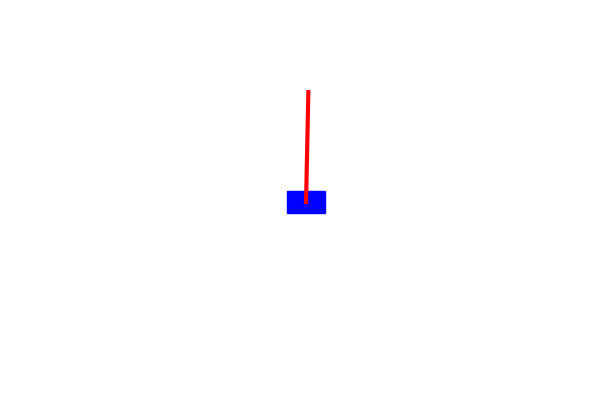

In [ ]:
!cd /content/RL_course_2/ && python run_env.py

from IPython.display import Image, display
gif_path = 'RL_course_2/cartpole_test.gif'
try:
    display(Image(filename=gif_path, width=500))
except FileNotFoundError:
    print(f"Ошибка: Файл GIF '{gif_path}' не найден.")

### Обучение DQN

Теперь перейдем к обучению нашего DQN-агента.

Далее в терминал будет выводиться номер эпизода, награда за него и эпсилон ε, актуальная для этого эпизода.

Можно увидеть, что эпсилон (вероятность совершения случайного действия) со временем экспонентециально уменьшается, это соответствует нашей деградирующей ε-жадной стратегии (decaying epsilon-greedy strategy).

In [ ]:
!cd /content/RL_course_2/ && python gymnasium_env_RL_course/envs/cartpole_DQN_train.py

/content/RL_course_2/gymnasium_env_RL_course/envs/cartpole_DQN_train.py:177: SyntaxWarning: invalid escape sequence '\ '
  plt.title(f'Скользящее среднее наград (M = {window_size}),\n$\\gamma = ${GAMMA}, $\\epsilon_d$ = {EPSILON_DECAY}, $learning\ rate = ${LR}, Normalization = {normalizaton}, seed = {seed}')
/usr/local/lib/python3.12/dist-packages/gymnasium/spaces/box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
Episode 1/500, Reward: 14.0, Epsilon: 0.997
Episode 2/500, Reward: 56.0, Epsilon: 0.994
Episode 3/500, Reward: 13.0, Epsilon: 0.991
Episode 4/500, Reward: 31.0, Epsilon: 0.988
Episode 5/500, Reward: 12.0, Epsilon: 0.985
Episode 6/500, Reward: 11.0, Epsilon: 0.982
Episode 7/500, Reward: 17.0, Epsilon: 0.979
Episode 8/50

### Оценка работы обученного агента

Посмотрим на графики обучения:
- Тонкая линия - награды за эпизод, но поскольку эпизоды во многом случайны, эти данные довольно шумные
- Толстая линия - Скользящее среднее (Running Mean) наград за эпизод, для фильтрации шумов

Мы можем видеть, что несмотря на то что обучение нестабильно (это нормально для DQN), средняя награда все же растет

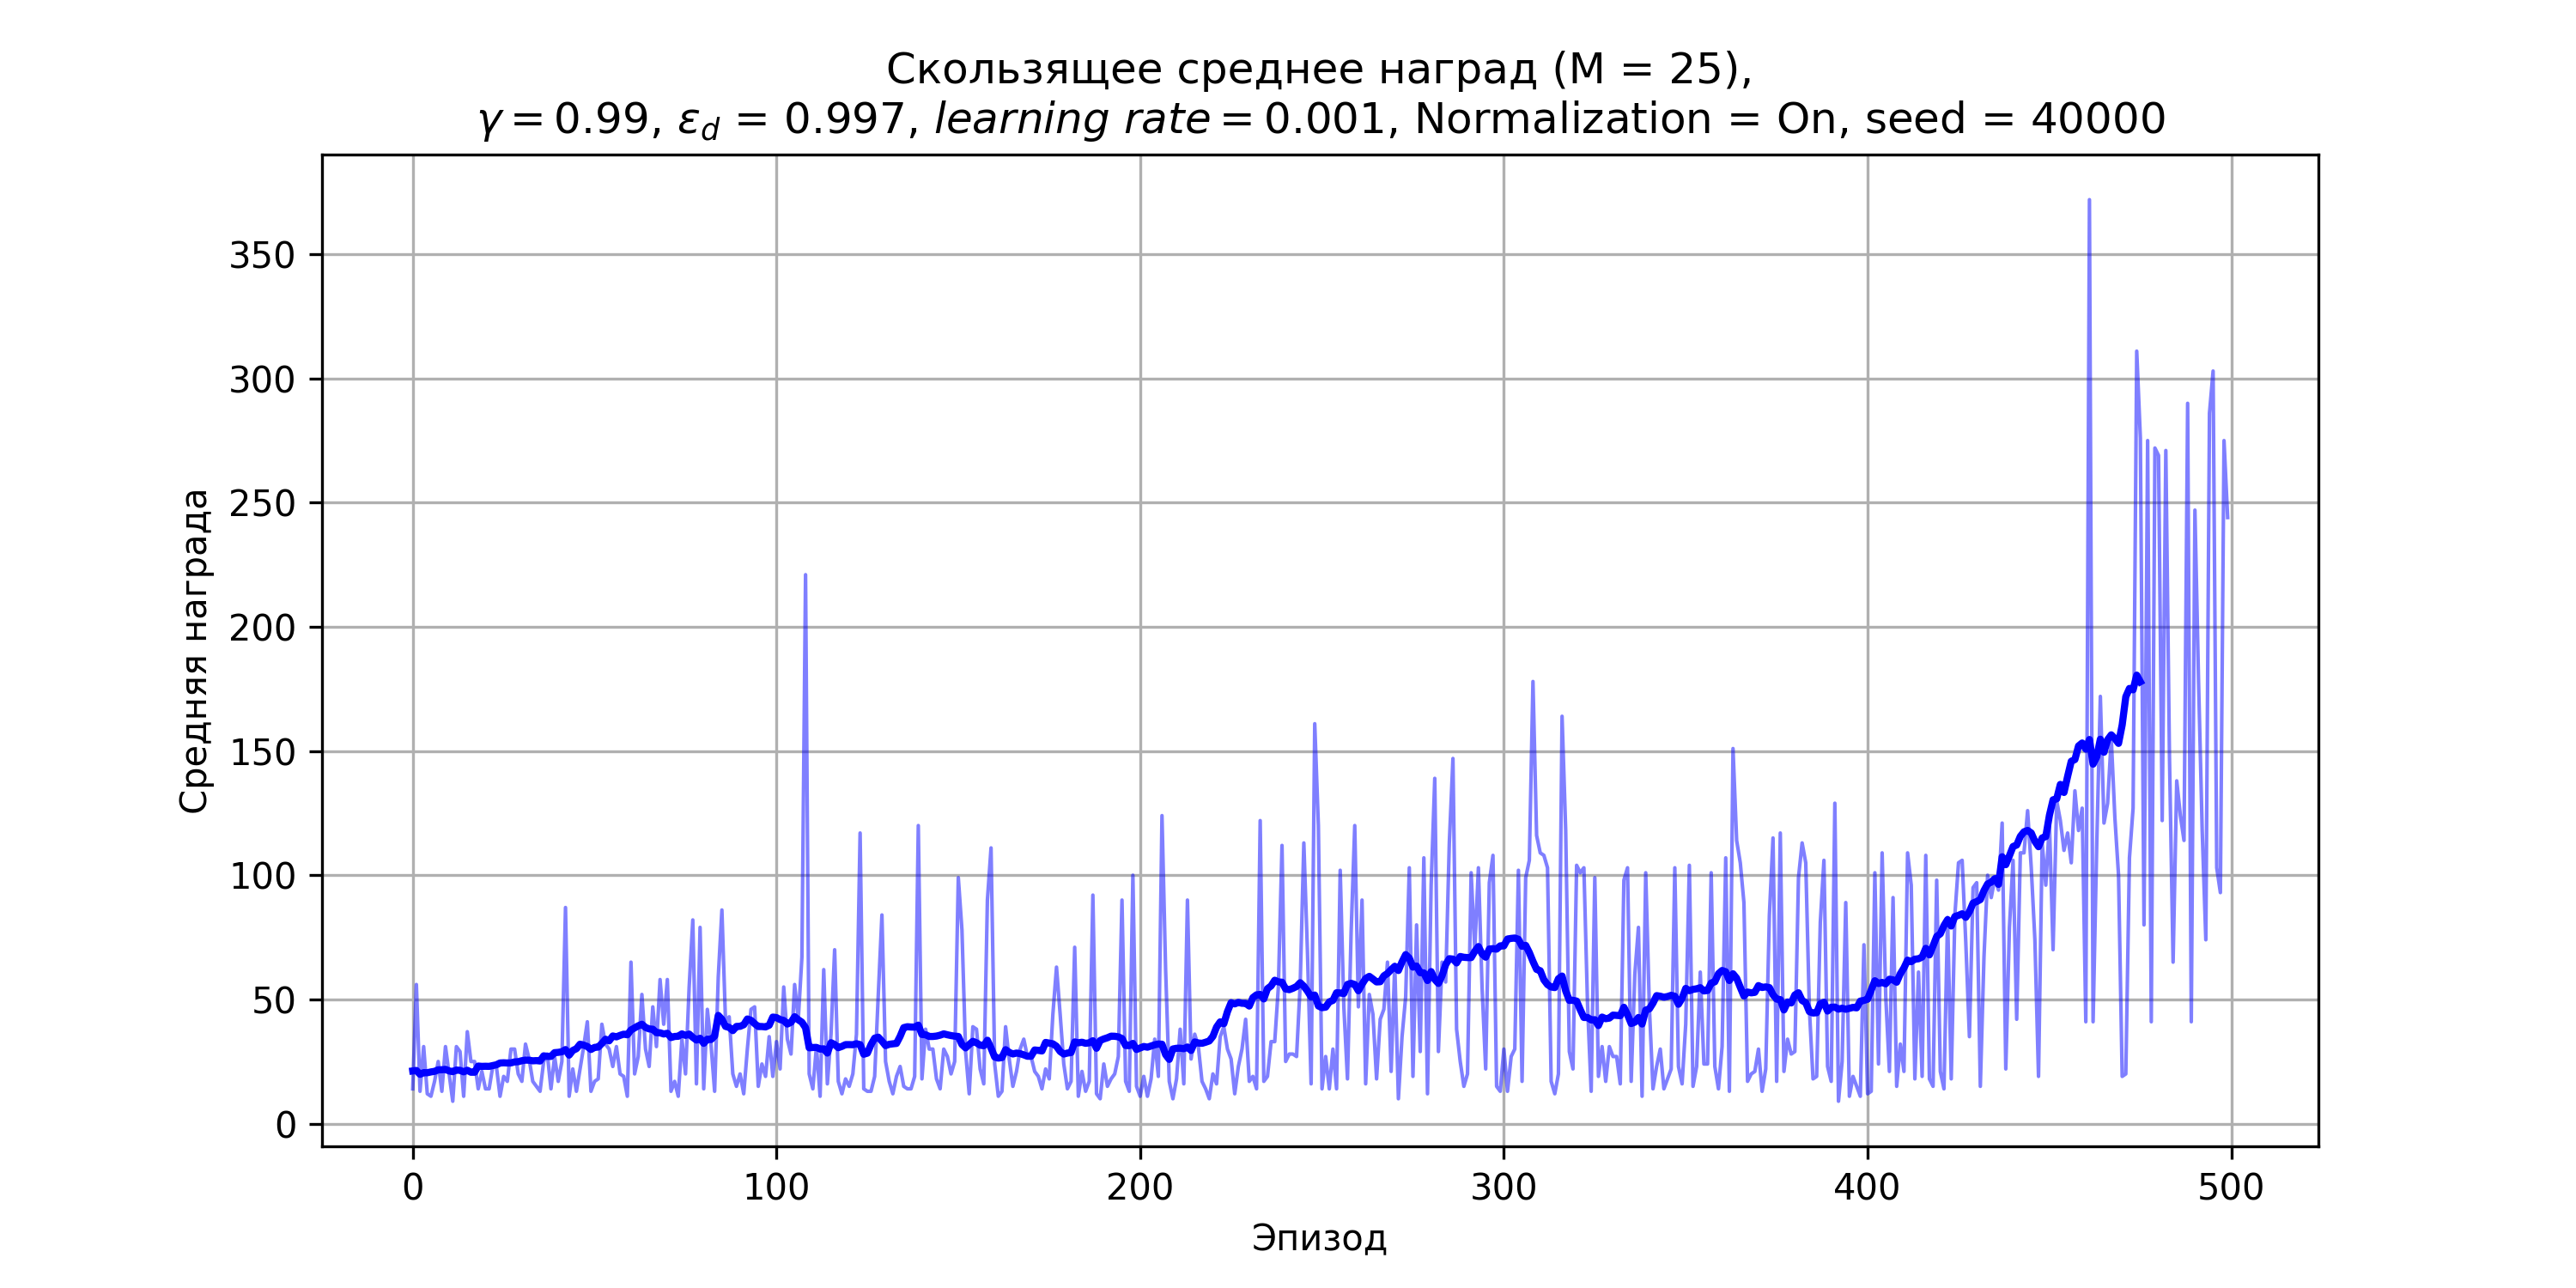

In [ ]:
image_path = 'RL_course_2/training_DQN_RunMean.png'
try:
    display(Image(filename=image_path, width=1000))
except FileNotFoundError:
    print(f"Ошибка: Файл изображения '{image_path}' не найден.")

Посмотрим, как работает наш DQN-агент:

Модель загружена
/usr/local/lib/python3.12/dist-packages/gymnasium/spaces/box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
Оценка эпизода 1: Награда = 500.0
Оценка эпизода 2: Награда = 500.0
Оценка эпизода 3: Награда = 500.0
Оценка эпизода 4: Награда = 500.0
Оценка эпизода 5: Награда = 500.0
Оценка эпизода 6: Награда = 500.0
Traceback (most recent call last):
  File "/content/RL_course_2/run_catpole_DQN.py", line 63, in <module>
    img = env.render()
          ^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gymnasium/core.py", line 337, in render
    return self.env.render()
           ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/common.py", line 409, in render
    return s

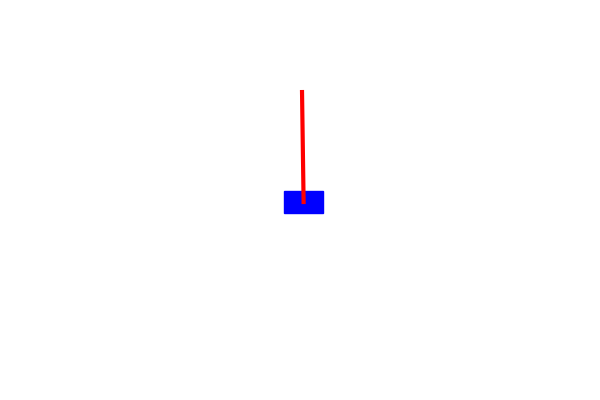

In [ ]:
!cd /content/RL_course_2/ && python run_catpole_DQN.py

gif_path = 'RL_course_2/cartpole_test_DQN.gif'
try:
    display(Image(filename=gif_path, width=500))
except FileNotFoundError:
    print(f"Ошибка: Файл GIF '{gif_path}' не найден.")

### Не стесняйтесь пробовать менять среду и гиперпараметры для получения разных результатов, этот ноутбук создан именно для этого!

Например, можно изменить начальное положение в среде, вынуждая агента сначала перебросить маятник в вертикальное положение, а уже потом его удерживать (конечно, для этого надо изменить условия завершения эпизода и многое другое)

Интересный пример решения этой проблемы в железе:
[DQN обратный маятник с переворотом](https://www.youtube.com/watch?v=XMn1FI9_f8k)